In [1]:
import tensorflow as tf
import random
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
mnist = tf.keras.datasets.mnist
# mnist dataset을 load한다.
(x_train, y_train),(x_test, y_test) = mnist.load_data()
# minmax 스케일링을 한다. 이는 이미지 전처리의 가장 보편적인 방법 중 하나이다.
x_train = x_train.reshape(60000, 784).astype('float32') / 255.0
x_test = x_test.reshape(10000, 784).astype('float32') / 255.0
print(x_train.shape, x_train.dtype)

(60000, 784) float32


In [3]:
y_unique_num = len(np.unique(y_train))
y_train = np_utils.to_categorical(y_train, y_unique_num)
y_test = np_utils.to_categorical(y_test, y_unique_num)
y_train[:5]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

In [4]:
x_train.shape, x_test.shape

((60000, 784), (10000, 784))

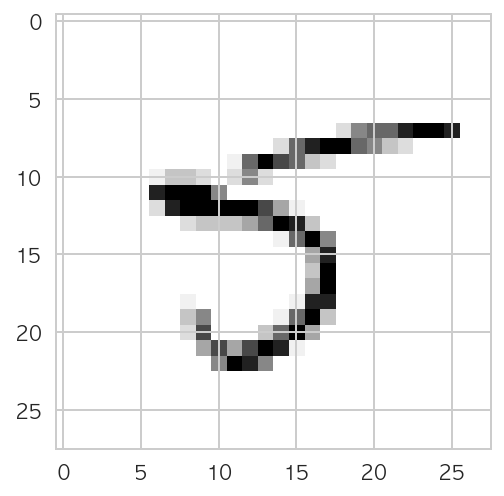

In [5]:
r = random.randint(0, x_train.shape[0] - 1)
plt.imshow(
    x_train[r].reshape(28, 28),
    cmap="Greys",
    interpolation="nearest" # 중간에 비어있는 값 처리
)
plt.show()

In [22]:
class DNNModel:
    def __init__(self, config):
        self.config = config
        self.endpoints = {}
        self.graph = tf.Graph()
        
    def build_net(self, x_placeholder, y_placeholder):
        with self.graph.as_default():
            with tf.variable_scope(self.config["name"]):

                self.X = x_placeholder
                self.y = y_placeholder

                layer_output_li = []
                for idx, n in enumerate(self.config["n_li"][:-1]):
                    with tf.name_scope("Layer_" + str(idx)) as scope:
                        previous_dim = self.config["n_li"][idx]
                        next_dim = self.config["n_li"][idx + 1]
                        shape = [previous_dim, next_dim]
                        pre_layer_output = layer_output_li[-1] if idx > 0 else self.X
                        self.__set_weight_and_bias(idx, shape)
                        layer = self.__set_layer_endpoint(idx, pre_layer_output)
                        layer_output_li.append(layer)

            with tf.name_scope("Cost") as scope:
                self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=self.logits, labels=self.y))
                cost_sum = tf.summary.scalar("Cost", self.cost)
            
            self.predict = tf.argmax(self.logits, 1)
            correct_prediction = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.y, 1))
            self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
            
    def __set_weight_and_bias(self, idx, shape):
        if self.config["initializer_li"][idx] == "random_normal":
            self.endpoints["W_" + str(idx)] = tf.Variable(tf.random_normal(shape), name = "W_" + str(idx))
        elif self.config["initializer_li"][idx] == "xavier":
            self.endpoints["W_" + str(idx)] = tf.get_variable("W_" + str(idx), shape=shape, 
                                initializer=tf.contrib.layers.xavier_initializer())
        self.endpoints["b_" + str(idx)] = tf.Variable(tf.random_normal(shape[1:]), name = "b_" + str(idx))
        W_hist = tf.summary.histogram("W_hist_" + str(idx), self.endpoints["W_" + str(idx)])
        b_hist = tf.summary.histogram("b_hist_" + str(idx), self.endpoints["b_" + str(idx)])
    
    def __set_layer_endpoint(self, idx, pre_layer_output):
        W = self.endpoints["W_" + str(idx)]
        b = self.endpoints["b_" + str(idx)]
        if idx + 1 == len(self.config["n_li"][:-1]):
            self.logits = tf.matmul(pre_layer_output, W) + b
            layer_hist = tf.summary.histogram("Layer_hist_" + str(idx), self.logits)
            return self.logits
        if self.config["activation_li"][idx] == "sigmoid":
            self.endpoints["layer_" + str(idx)] = tf.sigmoid(tf.matmul(pre_layer_output, W) + b)
        elif self.config["activation_li"][idx] == "relu":
            self.endpoints["layer_" + str(idx)] = tf.nn.relu(tf.matmul(pre_layer_output, W) + b)
        layer_hist = tf.summary.histogram("Layer_hist_" + str(idx), self.endpoints["layer_" + str(idx)])       
        return self.endpoints["layer_" + str(idx)]

In [21]:
def train(model, X_train, y_train, lr=1e-4, epoch=15, batch_size=200):
    with model.graph.as_default():
        x_placeholder = tf.placeholder(tf.float32, shape=[None, model.config["n_features"]], name="X")
        y_placeholder = tf.placeholder(tf.float32, shape=[None, model.config["n_class"]], name="y")

    model.build_net(x_placeholder, y_placeholder)
    
    with tf.Session(graph=model.graph) as sess:
        train_op = tf.train.AdamOptimizer(learning_rate=lr).minimize(model.cost)
        init = tf.global_variables_initializer()
        merged_summary = tf.summary.merge_all()
        writer = tf.summary.FileWriter("./logs", sess.graph)
        sess.run(init)
        for step in range(epoch):
            total_batch = int(len(X_train)/batch_size)
            c_avg = 0
            for i in range(total_batch):
                batch_x = X_train[batch_size*i : batch_size*(i+1)]
                batch_y = y_train[batch_size*i : batch_size*(i+1)]
                summary, c, _  = sess.run([merged_summary, model.cost, train_op], 
                                              feed_dict={model.X: batch_x, model.y: batch_y})
                c_avg = c_avg + (c/total_batch)
                writer.add_summary(summary, i)
            print(step, c_avg)
        saver = tf.train.Saver()
        saver.save(sess, './checkpoint/' + model.config["name"] + '.chkp')

In [20]:
def predict(model, x_test):
    with tf.Session(graph=model.graph) as sess:
        saver = tf.train.Saver()
        saver.restore(sess, './checkpoint/' + model.config["name"] + '.chkp')
        return sess.run([model.predict], feed_dict={model.X : x_test})

def accuracy(model, x_test, y_test):
    with tf.Session(graph=model.graph) as sess: 
        saver = tf.train.Saver()
        saver.restore(sess, './checkpoint/' + model.config["name"] + '.chkp')
        return sess.run([model.accuracy], feed_dict={model.X : x_test, model.y : y_test})

In [9]:
n_features = x_train.shape[1]
n_class = len(y_train[0])
config = {
    "name" : "dnn_model",
    "n_features" : n_features,
    "n_class" : n_class,
    "n_li" : [n_features, 1000, 1000, 1000, n_class],
    "initializer_li" : ["xavier", "xavier", "xavier", "xavier"],
    "activation_li" : ["relu", "relu", "relu", None]
}
dnn_model = DNNModel(config)

In [10]:
%%time
train(dnn_model, x_train, y_train, epoch=15)

0 0.6629932990173493
1 0.23762066062539813
2 0.17216268016025432
3 0.13428670282475652
4 0.10850845566640302
5 0.08941298353951423
6 0.07470236716326326
7 0.06300923381466421
8 0.053577517019584735
9 0.04564294106016557
10 0.039113987314049185
11 0.03361764366117619
12 0.029017086114423947
13 0.02516607346090801
14 0.02192044693355759
CPU times: user 25min 28s, sys: 15.2 s, total: 25min 43s
Wall time: 5min 26s


In [11]:
accuracy(dnn_model, x_test, y_test)

INFO:tensorflow:Restoring parameters from ./checkpoint/dnn_model.chkp


[0.9749]

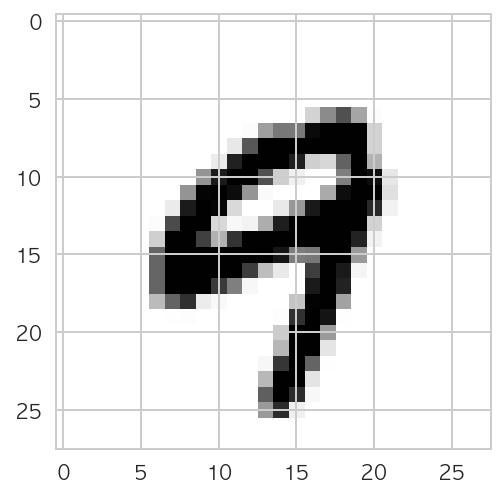

INFO:tensorflow:Restoring parameters from ./checkpoint/dnn_model.chkp


9

In [16]:
r = random.randint(0, x_test.shape[0] - 1)
plt.imshow(
    x_test[r].reshape(28, 28),
    cmap="Greys",
    interpolation="nearest" # 중간에 비어있는 값 처리
)
plt.show()
predict(dnn_model, x_test[r].reshape(1, 784))[0][0]